## Is French Wine Overpriced?

## With this data, your goal is to assess whether French Wine is overpriced, relative to similar wines of similar quality from different countries.

The structure of this research is to use prediction by inference to answer the overall question. A series of models will be explored, and their effectiveness will be considered, through the consideration of their Mean Standard Error (MSE) and R-squared values. The best performing model will be used to assess whether French wine is overpriced, relative to similar wines of similar quality from different countries.

## Reading in the relevant packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy.stats import ttest_1samp
from ISLP import load_data
from ISLP.models import ModelSpec as MS, summarize, poly
from sklearn.utils import resample

## Reading in the data

In [2]:
wines = pd.read_csv("wines.csv")
wines.columns

Index(['price', 'points', 'variety', 'country', 'province', 'description',
       'review_sentiment', 'wine_color'],
      dtype='object')

**Description of the variables**

The variable along with its description and data type is given below:

- **price** - price of the wine per bottle (type = numerical)
- **points** - the rating given for the wine. The higher the points, the better the wine rating. (type = numerical)
- **variety** - the variety of wine in the bottle (type = text)
- **country** - the country in which the wine is from (type = text)
- **province** - the region in which the wine is from (type = text)
- **description** - the text review of the wine (type = text)
- **review_sentiment** - derived from a simple text mining method (type = numerical)
- **wine_color** - the color of the wine (type = text)


The **points** and **review_sentiment** variables represent wine quality

The **variety** and **wine_color** variables represent wine type

**price** is what we are predicting

**Variable Exploration**

It is important to explore the continuous variables, because if they are skewed this will effect the ability to perform linear regression, as it assumes a normal distribution for its variables

C:\Users\info\OneDrive - University of Bristol\Year 1\Anaconda\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


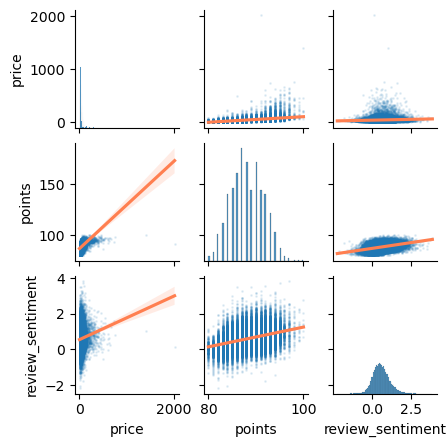

In [3]:
sns.pairplot(
data=wines,
kind="reg",
plot_kws=dict(scatter_kws=dict(s=1, alpha=0.1), line_kws=dict(color="coral")),
size=1.5,
)

The histogram for price shows a positive skew. As a result, the price variable would benefit from undergoing a log transformation to achieve a normal distribution. The other continuous variables show a normal distribution, and therefore no transformation is needed.

In [4]:
# Log transform the 'price' variable
wines['price'] = np.log(wines['price'])

It is worth checking that this transformation has been successful

C:\Users\info\OneDrive - University of Bristol\Year 1\Anaconda\Lib\site-packages\seaborn\axisgrid.py:2095: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


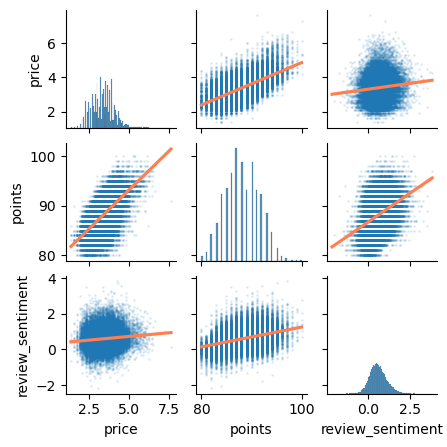

In [5]:
sns.pairplot(
data=wines,
kind="reg",
plot_kws=dict(scatter_kws=dict(s=1, alpha=0.1), line_kws=dict(color="coral")),
size=1.5,
)

The histogram now shows a normal distribution across all of the variables. This shows that the log transformation of the **price** variable is successful.

The decision has been made to remove the **description** variable, as the **review_sentiment** variable is the product of a text mining method that takes into account these review descriptions anyway!

In [6]:
wines = wines.drop(['description'],
                   axis=1)

## Modelling

**Model Exploration**

For this section, a selection of models are considered and compared to see which is the most successful at mapping the data. In this case, a linear regression model, KNN (where k=20) and a random forest are explored. In order to explore the efficiency of the models, the relationship between quality and price is explored. These models have been chosen in particular, as they are more inflexible than neural networks, which is more useful for inference questions, as the relationships between the variables and the predictions can be ascertained more easily.

The categorical variables of **country**, **variety** and **wine_color** are one-hot encoded to numerical variables so that they can be used in the model setup

In [7]:
# One-hot encoding the country, variety, and wine_color variables
country_encoded = pd.get_dummies(wines[['country']], drop_first=True)
variety_encoded = pd.get_dummies(wines[['variety']], drop_first=True)
color_encoded = pd.get_dummies(wines[['wine_color']], drop_first=True)

The original categorical columns are removed and the encoded columns are added back to the dataframe. The feature matrix and the target variable (**price**) are defined.

In [8]:
# Dropping the original country, variety, and wine_color columns from the wines DataFrame
wines = wines.drop(['country', 'variety', 'wine_color'], axis=1)

# Adding the encoded country, variety, and wine_color columns to the wines DataFrame
wines = pd.concat([wines, country_encoded], axis=1)
wines = pd.concat([wines, variety_encoded], axis=1)
wines = pd.concat([wines, color_encoded], axis=1)

# Defining the X_continuous and X_groups
X_continuous = wines.drop(["price", "province"], axis=1)
X_groups = pd.get_dummies(wines[['province']], drop_first=True)
y = wines["price"]

# Combining the continuous and categorical features
X = pd.concat([X_continuous, X_groups], axis=1)

The data is split into training and testing sets with 80% for training and 20% for testing. This enables us to explore which model performs best by looking at the MSE's across the training and testing data.

In [9]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

The feature data is scaled using StandardScaler to standardize the features.

In [10]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

The three models (Linear Regression, KNN, and Random Forest) are trained on the scaled training data.

In [11]:
# Fitting the models
linearmodel = LinearRegression().fit(X_train_scaled, y_train)
knnmodel = KNeighborsRegressor(n_neighbors=20).fit(X_train_scaled, y_train)
rfmodel = RandomForestRegressor(n_estimators=100, random_state=1).fit(X_train_scaled, y_train)

A test grid is created to predict prices over a range of wine quality scores (**points**). The continuous variables are set to their mean values and one-hot encoded variables set to 0. The test grid is then scaled. This is purely to explore the relationship between wine quality and price, to see which model is the best at representing this relationship

In [12]:
# Initializing the test grid with the range of points
test_grid_base = pd.DataFrame(np.arange(80, 101, 1), columns=["points"]) #The points data ranges from 80-100.

# Setting review_sentiment to its mean value
test_grid_base["review_sentiment"] = wines.review_sentiment.mean()

# Initializing the encoded variety and wine_color columns to their mean values
for col in variety_encoded.columns:
    test_grid_base[col] = wines[col].mean()
for col in color_encoded.columns:
    test_grid_base[col] = wines[col].mean()

# Initializing the encoded country columns to 0
for col in country_encoded.columns:
    test_grid_base[col] = 0

# Ensuring the order of columns matches the training data
test_grid_base = test_grid_base.reindex(columns=X.columns, fill_value=0)

# Scaling the test grid
test_grid_scaled = scaler.transform(test_grid_base)

Price predictions are made using the trained models on the scaled test grid.

In [13]:
# Predict prices using the pre-trained models
linear_preds = linearmodel.predict(test_grid_scaled)
knn_preds = knnmodel.predict(test_grid_scaled)
rf_preds = rfmodel.predict(test_grid_scaled)

The Mean Squared Error (MSE) and R-squared values for the training and testing sets are calculated and printed for each model. This is to assess the model performance, to deduce which is the best model to use moving forward

Linear Model Training Mean Squared Error (MSE): 0.19773222140703242
Linear Model Testing Mean Squared Error (MSE): 2.096911416371497e+21
Linear Model Training R-squared (R2): 0.5577837406035611
Linear Model Testing R-squared (R2): -4.732509580006584e+21
KNN Model Training Mean Squared Error (MSE): 0.17214321685024872
KNN Model Testing Mean Squared Error (MSE): 0.1885214323124561
KNN Model Training R-squared (R2): 0.6150120152684452
KNN Model Testing R-squared (R2): 0.5745268600811513
Random Forest Model Training Mean Squared Error (MSE): 0.03245843866822835
Random Forest Model Testing Mean Squared Error (MSE): 0.220621558180705
Random Forest Model Training R-squared (R2): 0.927408647758194
Random Forest Model Testing R-squared (R2): 0.50208023596301


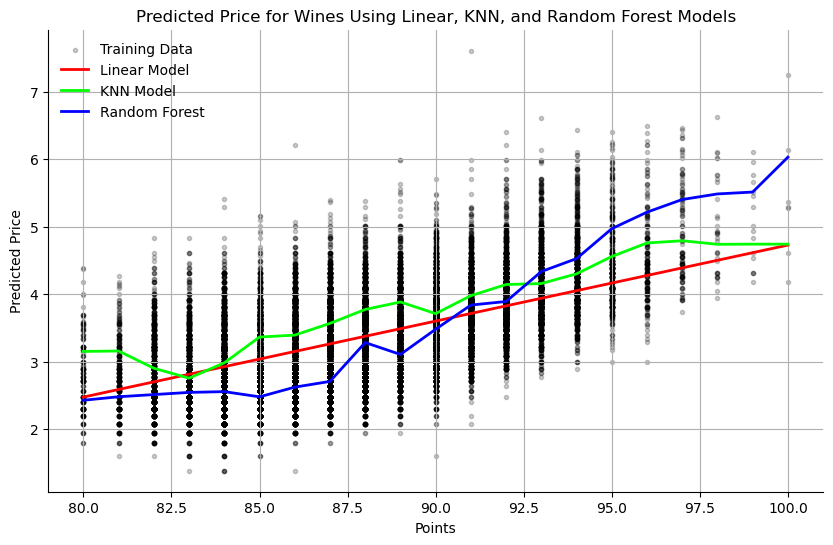

In [14]:
# Calculate and print the MSE and R-squared values for training and testing sets
def print_metrics(model_name, y_train, y_train_pred, y_test, y_test_pred):
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f"{model_name} Training Mean Squared Error (MSE):", mse_train)
    print(f"{model_name} Testing Mean Squared Error (MSE):", mse_test)
    print(f"{model_name} Training R-squared (R2):", r2_train)
    print(f"{model_name} Testing R-squared (R2):", r2_test)

print_metrics("Linear Model", y_train, linearmodel.predict(X_train_scaled), y_test, linearmodel.predict(X_test_scaled))
print_metrics("KNN Model", y_train, knnmodel.predict(X_train_scaled), y_test, knnmodel.predict(X_test_scaled))
print_metrics("Random Forest Model", y_train, rfmodel.predict(X_train_scaled), y_test, rfmodel.predict(X_test_scaled))

# Plotting the relationship between points and predicted price for each model
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_continuous['points'], y, marker=".", color="k", alpha=0.2, label='Training Data')

# Plot predictions
plt.plot(test_grid_base['points'], linear_preds, color="red", linewidth=2, label="Linear Model")
plt.plot(test_grid_base['points'], knn_preds, color="lime", linewidth=2, label="KNN Model")
plt.plot(test_grid_base['points'], rf_preds, color="blue", linewidth=2, label="Random Forest")

# Labels and title
plt.xlabel("Points")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Wines Using Linear, KNN, and Random Forest Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


From the MSE scores, it appears that the KNN model performs best at predicting price with changes in the **points** variable. This is because the MSE scores for both the testing and training dataset are relatively low, and similar. The R-squared value for the testing data is also the greatest for this model, and it shows that 57.45% of the testing data is explained by this model. This suggests that the KNN model performs well for prediction, with no suggestion of overfitting. 

The Linear Regression model performs particularly poor, which suggests that the relationship is non-linear. The random forest has a relatively low testing MSE score, however the considerably lower training MSE could suggest overfitting, and it did not perform better than the KNN model either way. This research therefore uses the KNN for its subsequent analysis

**Cross-Validation**

To ensure that the best k value for the KNN model is used, cross-validation is undertaken. GridSearchCV is used to perform cross-validation and find the best k value for the KNN model. Cross-validation is useful for evaluating the model's performance by dividing the data into several folds and testing the model on each fold.a.

The best value of k is: 22
Best KNN Model Training Mean Squared Error (MSE): 0.1735881611835696
Best KNN Model Testing Mean Squared Error (MSE): 0.18821526065271682
Best KNN Model Training R-squared (R2): 0.61178048388944
Best KNN Model Testing R-squared (R2): 0.5752178574697533


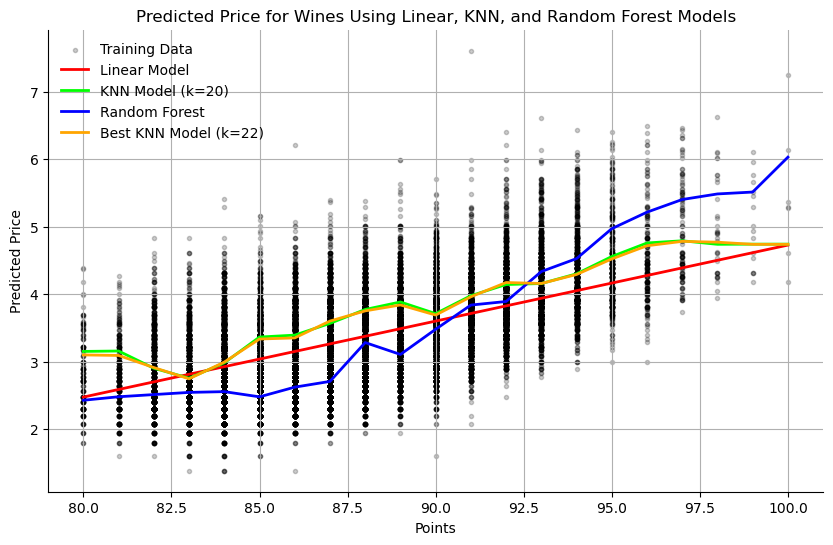

In [15]:
# Defining the parameter grid for GridSearchCV
param_grid = {'n_neighbors': np.arange(1, 50)}

# Initializing the KNN model
knn = KNeighborsRegressor()

# Initializing GridSearchCV with cross-validation
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fitting GridSearchCV
grid_search.fit(X_train_scaled, y_train)

# Retrieving the best K value
best_k = grid_search.best_params_['n_neighbors']
print(f"The best value of k is: {best_k}")

# Fitting the KNN model with the best K value
best_knnmodel = KNeighborsRegressor(n_neighbors=best_k).fit(X_train_scaled, y_train)

# Predicting on training and testing sets using the best KNN model
train_pred_best_knn = best_knnmodel.predict(X_train_scaled)
test_pred_best_knn = best_knnmodel.predict(X_test_scaled)

# Printing the MSE and R-squared values for the best KNN model
print_metrics("Best KNN Model", y_train, train_pred_best_knn, y_test, test_pred_best_knn)

# Predicting prices using the best KNN model for the test grid
best_knn_preds = best_knnmodel.predict(test_grid_scaled)

# Plotting the relationship between points and predicted price for each model including the best KNN model
plt.figure(figsize=(10, 6))

# Scatter plot of the original data
plt.scatter(X_continuous['points'], y, marker=".", color="k", alpha=0.2, label='Training Data')

# Plotting predictions
plt.plot(test_grid_base['points'], linear_preds, color="red", linewidth=2, label="Linear Model")
plt.plot(test_grid_base['points'], knn_preds, color="lime", linewidth=2, label="KNN Model (k=20)")
plt.plot(test_grid_base['points'], rf_preds, color="blue", linewidth=2, label="Random Forest")
plt.plot(test_grid_base['points'], best_knn_preds, color="orange", linewidth=2, label=f"Best KNN Model (k={best_k})")

# Labels and title
plt.xlabel("Points")
plt.ylabel("Predicted Price")
plt.title("Predicted Price for Wines Using Linear, KNN, and Random Forest Models")

# Legends and grid
plt.legend(frameon=False)
plt.grid(True)
sns.despine()

# Show plot
plt.show()


The output of the cross-validation shows that k=22 gives us the best output, with a slight reduction in testing data MSE and a slight increase in the testing data R-quared, and therefore this is used when exploring prediction by inference. Before exploring the prediction by inference, the KNN model bias is explored to understand how the model views the data.

**Exploring bias between quality and price**

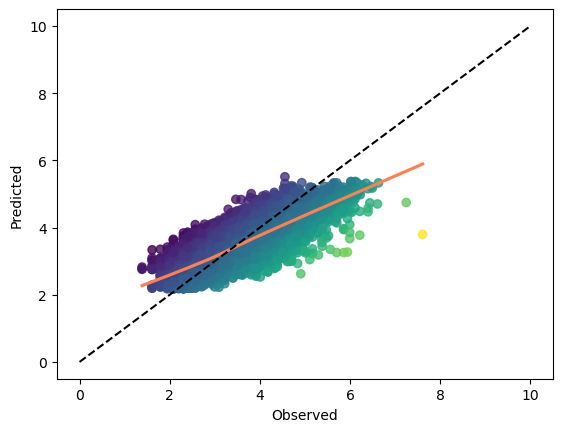

In [16]:
knnmodel = KNeighborsRegressor(n_neighbors=22).fit(X_train_scaled, y_train)

# Predicting on the training data to ensure the feature set is consistent
knn_preds = knnmodel.predict(X_train_scaled)

# Computing the residuals for the training data
knn_residual = y_train - knn_preds

# Plotting the residuals
sns.regplot(
    x=y_train,
    y=knn_preds,
    lowess=True,
    line_kws=dict(color="coral"),
    scatter_kws=dict(c=knn_residual.values, color=None),
)
plt.plot((0, 10), (0, 10), color="k", linestyle="--")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.show()


The plot above shows model 'overpredicted' prices to the left of the dashed line, and 'underpredicted' values to the right of the dashed line. Following the red line, the mispredictions are fairly consistent across the 
observed valuesof pricey.ted.


It’s hard to predict the cheaper and more expensive wines, but the model does well for the prices in between. The black dashed line appears to split the data points relatively evenly which suggests that there is no issue of skew for the predictions. This places confidence that the model is performing as we expect.

**Exploring bias across the countries**

Before exploring whether French wines are overpriced, it is important to consider whether the model is bias across the countries. This is achieved by plotting the residuals against the predicted values. The residuals help to identify if there are any systematic errors in the model predictions for different countries.

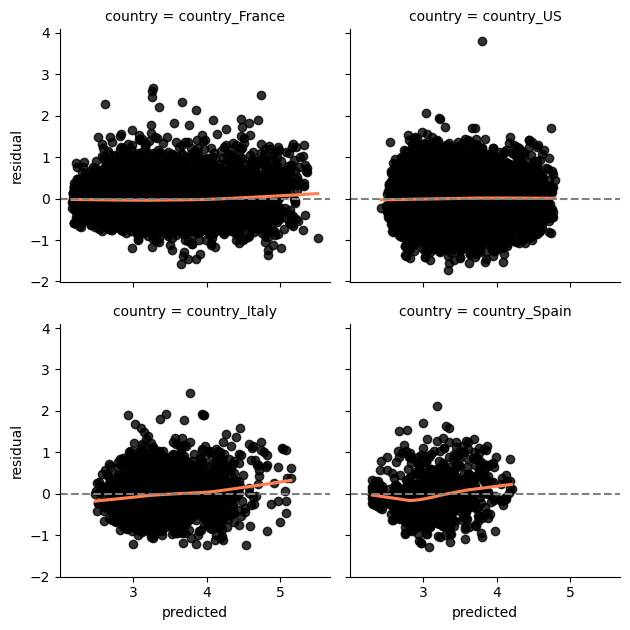

In [17]:
# Creating a DataFrame with the actual, predicted, and residual values
wines_with_predictions = wines.loc[X_train.index].copy()
wines_with_predictions['predicted'] = knn_preds
wines_with_predictions['residual'] = knn_residual

# Creating a DataFrame with country information
country_encoded_columns = country_encoded.columns.tolist()
wines_with_predictions['country'] = wines_with_predictions[country_encoded_columns].idxmax(axis=1)

# Plotting with seaborn
facets = sns.lmplot(
    data=wines_with_predictions,
    y="residual",
    x="predicted",
    col="country",
    col_wrap=2,
    lowess=True,
    scatter_kws=dict(color="black"),
    line_kws=dict(color="coral"),
    height=3.2,
    aspect=1,
)

# Adding horizontal reference lines at y=0
for ax in facets.axes.flatten():
    ax.axhline(0, color="grey", linestyle="--")

plt.show()



There is no apparent structure in the residuals for France and the US. Although there is no concerning trends in the residuals for Italy and Spain, the residual plots do suggest that the model predictions are slightly too large for smaller prices and slightly too small for larger prices for both Italy and Spain.  

Although these residuals are not extreme, it is useful to understand and consider when exploring whether French wine is overpriced

**Prediction by inference**

Now that the best value of k has been deduced, this optimum KNN model(k=22) is used for prediction by inference to understand whether french wines are overpriced, in relation to the research question. To explore this, price predictions are made for each country individually, and the mean average price predictions are compared.

To achieve this, a test grid is generated, which sets the continuous and one-hot encoded variables to their mean values. This means that the quality and type of wines is kept constant. Step by step, each country is modelled by setting its value to 1, whilst prescribing the remaining countries a value of 0. This is repeated for each country, to understand how these prices change across each country.

Price difference for country_France compared to France: 0.0
Price difference for country_Italy compared to France: -0.6164389083256445
Price difference for country_Spain compared to France: -0.458227786500792
Price difference for country_US compared to France: -0.07978848976798059


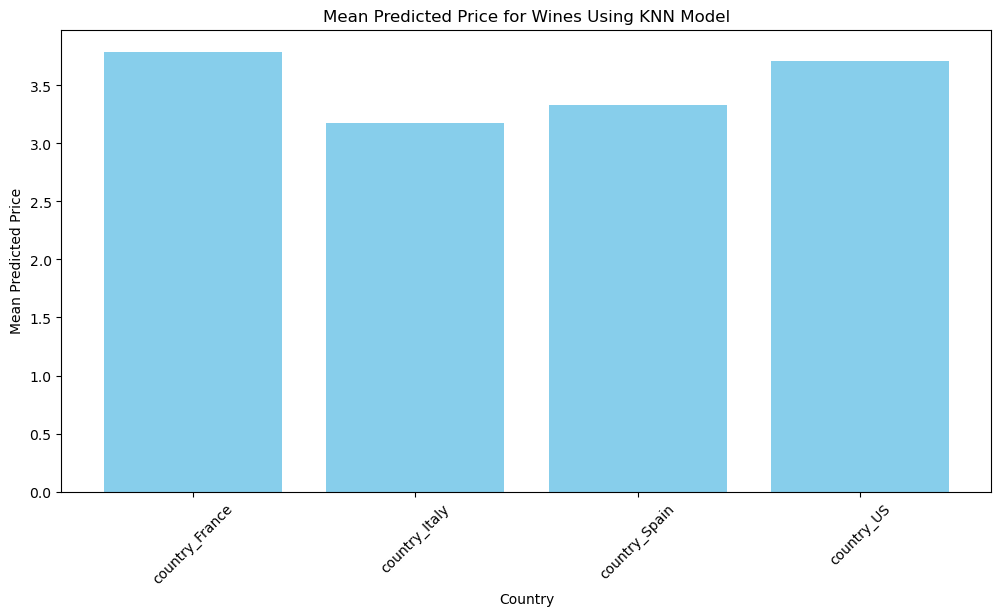

Test Grid for France:
      points  review_sentiment  country_France  country_Italy  country_Spain  \
0  88.116382          0.594312               1              0              0   
1  88.116382          0.594312               1              0              0   
2  88.116382          0.594312               1              0              0   
3  88.116382          0.594312               1              0              0   
4  88.116382          0.594312               1              0              0   

   country_US  variety_Champagne Blend  variety_Chardonnay  variety_Merlot  \
0           0                 0.016441            0.193108        0.072564   
1           0                 0.016441            0.193108        0.072564   
2           0                 0.016441            0.193108        0.072564   
3           0                 0.016441            0.193108        0.072564   
4           0                 0.016441            0.193108        0.072564   

   variety_Pinot Noir  varie

In [18]:
# Defining X and y
X = wines.drop(["price", "province"], axis=1)
y = wines["price"]

# Setting the random seed for reproducibility
np.random.seed(1)

# Fitting the best KNN model
knnmodel = KNeighborsRegressor(n_neighbors=22).fit(X, y)

# Initializing the test grid with the range of points set to their mean value
test_grid_base = pd.DataFrame(np.arange(80, 101, 1), columns=["points"])
test_grid_base["points"] = wines.points.mean()
test_grid_base["review_sentiment"] = wines.review_sentiment.mean()

# Initializing the encoded variety and wine_color columns to their mean values
for col in variety_encoded.columns:
    test_grid_base[col] = wines[col].mean()
for col in color_encoded.columns:
    test_grid_base[col] = wines[col].mean()

# Initializing the encoded country columns to 0
for col in country_encoded.columns:
    test_grid_base[col] = 0

# Ensuring that the order of columns matches the training data
test_grid_base = test_grid_base.reindex(columns=X.columns, fill_value=0)

# Function to update the test grid for each country. This function activates each country one at a time
def update_test_grid_for_country(test_grid, country):
    test_grid = test_grid.copy()
    for col in country_encoded.columns:
        test_grid[col] = 0
    test_grid[country] = 1
    return test_grid

# Calculating the mean predicted price for each country
country_means = {}

for country in country_encoded.columns:
    test_grid = update_test_grid_for_country(test_grid_base, country)
    
    # Ensuring that the order of columns matches the training data
    test_grid = test_grid[X.columns]
    
    # Predicting prices using the pre-trained KNN model
    knn_preds = knnmodel.predict(test_grid)
    
    country_means[country] = np.mean(knn_preds)

# Calculating the difference compared to France
price_differences = {country: mean_price - country_means['country_France'] for country, mean_price in country_means.items()}

# Printing the price differences
for country, difference in price_differences.items():
    print(f"Price difference for {country} compared to France: {difference}")

# Plotting the mean predicted price for each country
plt.figure(figsize=(12, 6))

# Bar chart of the mean predicted price for each country
plt.bar(country_means.keys(), country_means.values(), color="skyblue")

# Labels and title
plt.xlabel("Country")
plt.ylabel("Mean Predicted Price")
plt.title("Mean Predicted Price for Wines Using KNN Model")

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

# Displaying the test grid table for France as an example
test_grid_france = update_test_grid_for_country(test_grid_base, 'country_France')
print("Test Grid for France:")
print(test_grid_france.head())


The printed output values and the bar chart shows that for the same quality and type of wine, the average price of wine is greater (overpriced) for French wines in comparison to wines from every other country. This may have occured purely from the way that the data has been split during the model setup, and therefore bootstrapping is an important step to undertsand the uncertainty of these predictions. Bootstrapping assessed the robustness of model predictions, with the hope that this finding remains consistent throughout the different sampling of the data.

**Bootstrapping**

1000 bootstrap iterations are performed to explore the distribution of results.

Price difference for country_France compared to France: 0.0
Price difference for country_Italy compared to France: -0.6215109589631846
Price difference for country_Spain compared to France: -0.46837542302197477
Price difference for country_US compared to France: -0.0833418476148009
country_France - Min: 3.500085251734522, Max: 4.127233426363257
country_Italy - Min: 2.772268390902744, Max: 3.542349930648874
country_Spain - Min: 2.9407835716144883, Max: 3.60709482177135
country_US - Min: 3.3306826771523688, Max: 4.111511628195984


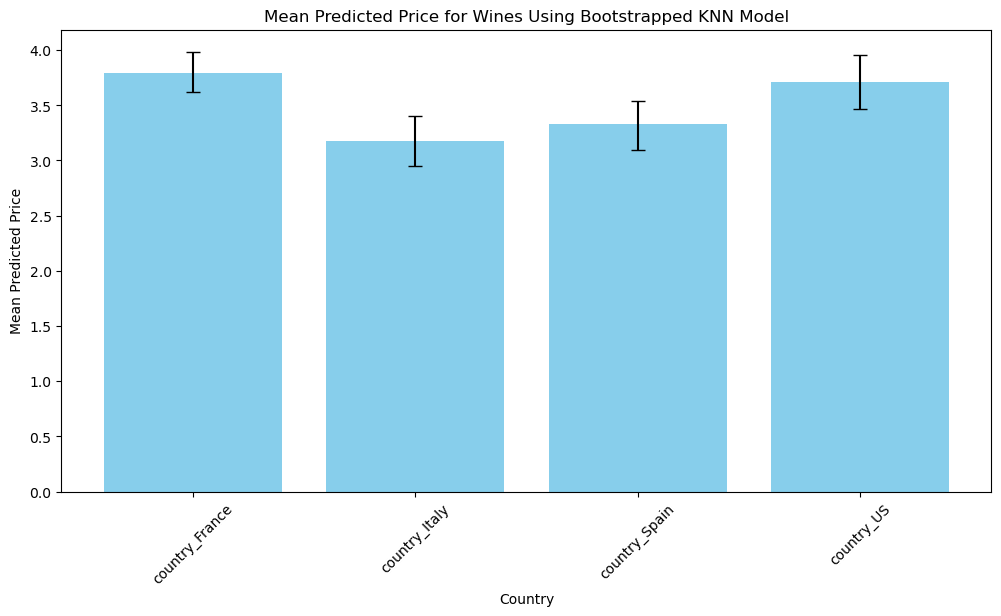

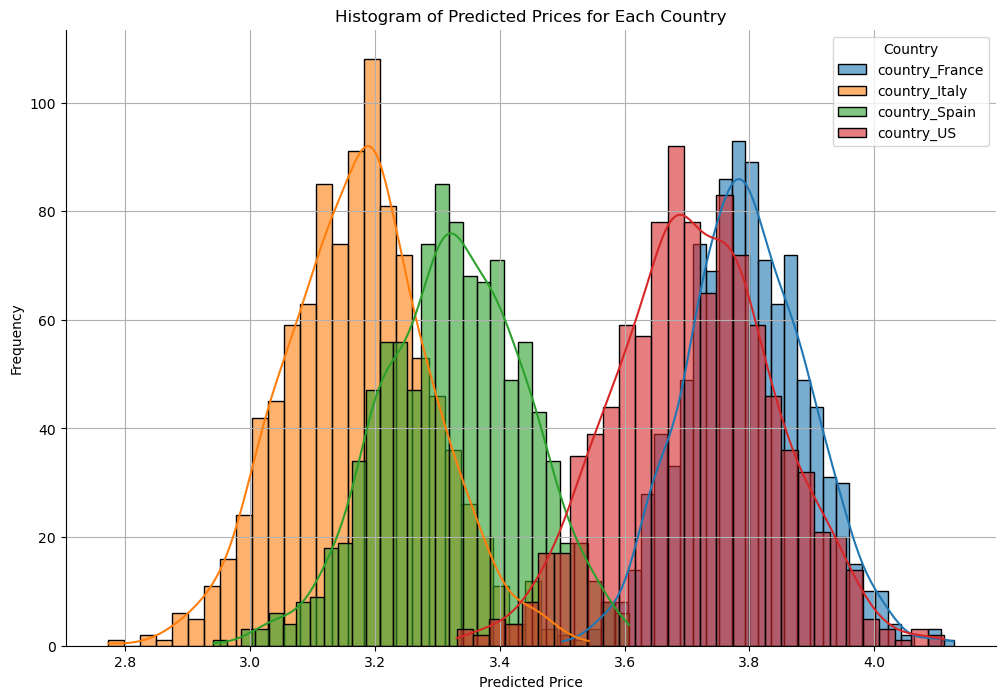

Test Grid for France:
      points  review_sentiment  country_France  country_Italy  country_Spain  \
0  88.116382          0.594312               1              0              0   
1  88.116382          0.594312               1              0              0   
2  88.116382          0.594312               1              0              0   
3  88.116382          0.594312               1              0              0   
4  88.116382          0.594312               1              0              0   

   country_US  variety_Champagne Blend  variety_Chardonnay  variety_Merlot  \
0           0                 0.016441            0.193108        0.072564   
1           0                 0.016441            0.193108        0.072564   
2           0                 0.016441            0.193108        0.072564   
3           0                 0.016441            0.193108        0.072564   
4           0                 0.016441            0.193108        0.072564   

   variety_Pinot Noir  varie

In [19]:
# Bootstrap sampling
n_bootstraps = 1000
bootstrap_country_means = {country: [] for country in country_encoded.columns}

for _ in range(n_bootstraps):
    # Sample with replacement
    X_sample, y_sample = resample(X, y)
    
    # Fitting the KNN model
    knnmodel = KNeighborsRegressor(n_neighbors=22).fit(X_sample, y_sample)
    
    # Initializing the test grid with the range of points set to their mean value
    test_grid_base = pd.DataFrame(np.arange(80, 101, 1), columns=["points"])
    test_grid_base["points"] = wines.points.mean()
    test_grid_base["review_sentiment"] = wines.review_sentiment.mean()
    
    # Initializing the encoded variety and wine_color columns to their mean values
    for col in variety_encoded.columns:
        test_grid_base[col] = wines[col].mean()
    for col in color_encoded.columns:
        test_grid_base[col] = wines[col].mean()
    
    # Initializing the encoded country columns to 0
    for col in country_encoded.columns:
        test_grid_base[col] = 0
    
    # Ensuring that the order of columns matches the training data
    test_grid_base = test_grid_base.reindex(columns=X.columns, fill_value=0)
    
    # Function to update the test grid for each country
    def update_test_grid_for_country(test_grid, country):
        test_grid = test_grid.copy()
        for col in country_encoded.columns:
            test_grid[col] = 0
        test_grid[country] = 1
        return test_grid
    
    # Calculating the mean predicted price for each country
    country_means = {}
    
    for country in country_encoded.columns:
        test_grid = update_test_grid_for_country(test_grid_base, country)
        
        # Ensure the order of columns matches the training data
        test_grid = test_grid[X.columns]
        
        # Predict prices using the pre-trained KNN model
        knn_preds = knnmodel.predict(test_grid)
        
        country_means[country] = np.mean(knn_preds)
    
    # Storing the mean prices for each country in the bootstrap sample
    for country, mean_price in country_means.items():
        bootstrap_country_means[country].append(mean_price)

# Calculating the mean and confidence intervals for each country
country_means_summary = {country: (np.mean(prices), np.percentile(prices, 2.5), np.percentile(prices, 97.5)) for country, prices in bootstrap_country_means.items()}

# Calculating the difference compared to France
price_differences = {country: (mean_price - country_means_summary['country_France'][0]) for country, (mean_price, _, _) in country_means_summary.items()}

# Printing the price differences
for country, difference in price_differences.items():
    print(f"Price difference for {country} compared to France: {difference}")

# Printing the minimum and maximum values for each country
for country, prices in bootstrap_country_means.items():
    print(f"{country} - Min: {np.min(prices)}, Max: {np.max(prices)}")

# Plotting the mean predicted price for each country
plt.figure(figsize=(12, 6))

# Bar chart of the mean predicted price for each country with error bars
countries = list(country_means_summary.keys())
means = [country_means_summary[country][0] for country in countries]
lower_bounds = [country_means_summary[country][1] for country in countries]
upper_bounds = [country_means_summary[country][2] for country in countries]

# Calculating the error bars
yerr = np.array([(means[i] - lower_bounds[i], upper_bounds[i] - means[i]) for i in range(len(means))]).T

plt.bar(countries, means, yerr=yerr, color="skyblue", capsize=5)

# Labels and title
plt.xlabel("Country")
plt.ylabel("Mean Predicted Price")
plt.title("Mean Predicted Price for Wines Using Bootstrapped KNN Model")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.show()

# Plot histogram distributions for each country on the same plot
plt.figure(figsize=(12, 8))

for country, prices in bootstrap_country_means.items():
    sns.histplot(prices, bins=30, kde=True, label=country, alpha=0.6)

plt.xlabel("Predicted Price")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Prices for Each Country")
plt.legend(title="Country")
plt.grid(True)
sns.despine()
plt.show()

# Display the test grid table for France as an example
test_grid_france = update_test_grid_for_country(test_grid_base, 'country_France')
print("Test Grid for France:")
print(test_grid_france.head())

From the bootstrap outputs, it appears that there is overlap between the price predictions for different countries, depending on the  data sampling. The histograms for the US and France overlap considerably, which shows that the price of French and US wines are more expensive than those from Italy and Spain.

It is interesting, that the distribution of predicted prices for each country overlaps with the distribution of that shown for French wines. This higlights the uncertainty of the predictions, and shows that a different sampling of the data could result in different conclusions. Despite this, throughout the majority of the bootstrapping samples, the price predictions for French wines appear to be more expensive. The overall conclusion remains that French wines tend to be more expensive on average, but the overlapping distributions reveal that the wine market is diverse, with considerable price variability within each country.

**Conclusions**

This work has explored different models: linear regression, KNN and Random Forest, in an attempt to accurately predict wine prices with respect to changes in quality. Using cross-validation, a KNN where k=22 was shown to be the optimum model.

This model was used for prediction as inference, which concluded that average French wine prices were overpriced (more expensive) when compared to the same type and quality of wine for different countries. The uncertainty surrounding these values were explored, and displayed consistently higher price predictions for French wines in comparison to other countries. Despite this, there was significant distribution cross over between French and US wines which suggests that the outcome could change depending on the data sampling. Another interesting note, is that all distributions overlapped with the French wine distributions, but these were at the upper limits and is very unlikely to occur. 

Although the conclusion is that French wines are overpriced relative to similar wines of similar quality from different countries, the KNN that explored changes in quality and its effect on price, showed slight model bias for Italian and Spanish wines. These residuals were not deemed as considerable, and was ultimately left, but it could pose potential limitations on the conclusions made and could require further investigation.